# Clustering Townsville Suburbs

## Introduction  
Townsville is a major regional center in Queensland, Australia. It has a population of over 193,000. It is a major government, commercial and defence center. The Townsville local government area covers 3,736 square kilometres. The area considered in this analysis is about 180 sq klms. Population density in the urban area is just over 1060 persons per sq km.
This project will seek to cluster the urban suburbs of Townsville. The features used in the cluster analysis can broadly be considered as Lifestyle factors. They are: Socio-Economic Indexes; Access to Public Transport; Animal Complaints; Crime Data; Access to Council Community Facilities; Access to Community Venues.  
The insights gained from this project would be useful to people moving too, or moving within the Townsville District. It can give people an idea of commonalities and differences between suburbs.


## Data Sources:   
Data was sourced from several online sites, in Excel and Json file formats.  
Excel and Json files from the Australian Bureau of Statistics and the Townsville City Council Website.  
Json files retrieved in response to API requests to Qld State Government Crime Database and FourSquare database.  
Some data preparation was done in the Excel files beforehand.  
Geolocation data was obtained using the OpenStreetMap Nominatim API.  

In [1]:
#Import all packages required

import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import requests

pd.options.display.float_format = '{:.2f}'.format

import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopy.distance

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.cm as cmx

#%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import folium # map rendering library

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA

In [2]:
# Load suburb names. These were cut and paste from council website into Excel. This allowed for editing of required suburbs
# This was the most efficient method to get this list

df = pd.read_excel('townsville_suburbs.xlsx')
df['Suburb'] = df['Suburb'].str.strip() # strip leading and trailing spaces

In [3]:
df.head()

,Suburb
0,Townsville City
1,Aitkenvale
2,Annandale
3,Belgian Gardens
4,Castle Hill


In [4]:
# get Townsville latitude and longitude

address = 'Townsville, Australia'

geolocator = Nominatim(user_agent="townsville_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Townsville are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Townsville are -19.2569391, 146.8239537.


In [5]:
# Add suburb latitude and longitude

# function to return each suburbs location
def findlocation(sub):
    city = ', Townsville'
    address = sub+city
    geolocator = Nominatim(user_agent="townsville_explorer")
    location = geolocator.geocode(address)
    return location 

for ind in df.index:
    locate = findlocation(df.loc[ind][0])
    df.loc[[ind],'latitude'] = locate.latitude
    df.loc[[ind],'longitude'] = locate.longitude

In [6]:
df.head()

,Suburb,latitude,longitude
0,Townsville City,-19.26,146.82
1,Aitkenvale,-19.30,146.77
2,Annandale,-19.31,146.78
3,Belgian Gardens,-19.25,146.79
4,Castle Hill,-19.26,146.80


In [7]:
# Add SocioEconomic Data. Excel spreadsheet sourced from the Australian Bureau of Statistics. Prepared in Excel.
# Socioeconomic factors include:
# Index of Relative Socio-economic Disadvantage (IRSD)
# Index of Relative Socio-economic Advantage and Disadvantage (IRSAD)
# Index of Economic Resources (IER) 
# Index of Education and Occupation (IEO)
# A higher number is better.

se_df = pd.read_excel('state_suburb_socioeconomic_indexs_2016.xlsx', sheet_name='Sheet1',index_col=None,na_values=['NA'],usecols = "A:E")
se_df['Suburb'] = se_df['Suburb'].str.strip() # strip leading and trailing spaces from suburb names.
df_ec = pd.merge(df, se_df, on='Suburb', how='inner')

# convert object data to numeric for processing
df_ec['rsed'] = pd.to_numeric(df_ec['rsed'])
df_ec['rsead'] = pd.to_numeric(df_ec['rsead'])
df_ec['ier'] = pd.to_numeric(df_ec['ier'])
df_ec['ieo'] = pd.to_numeric(df_ec['ieo'])

In [8]:
se_df.head()

,Suburb,rsed,rsead,ier,ieo
0,Townsville City,1055,1059,943,1094
1,Aitkenvale,940,937,915,964
2,Annandale,1077,1068,1069,1051
3,Belgian Gardens,1015,1021,966,1056
4,Castle Hill,1127,1164,1135,1169


In [9]:
df_ec.head()

,Suburb,latitude,longitude,rsed,rsead,ier,ieo
0,Townsville City,-19.26,146.82,1055,1059,943,1094
1,Aitkenvale,-19.30,146.77,940,937,915,964
2,Annandale,-19.31,146.78,1077,1068,1069,1051
3,Belgian Gardens,-19.25,146.79,1015,1021,966,1056
4,Castle Hill,-19.26,146.80,1127,1164,1135,1169


In [10]:
# Add bus shelters. Excel spreadsheet from City Council website.
# Counts the number of bus stops/shelters within a set radius of the suburb center.
# More bus stops indicate better access to public transport

pt_df = pd.read_excel('Bus_Shelters_Townsville.xlsx', sheet_name='Sheet1',index_col=None,na_values=['NA'],usecols = "A:G")

for ind in df_ec.index:
    count_stop = 0
    for ind2 in pt_df.index:
        coords_1 = (df_ec.iloc[ind,1],df_ec.iloc[ind,2])
        coords_2 = (pt_df.iloc[ind2,3],pt_df.iloc[ind2,4])
        #print(coords_1,coords_2)
        if (geopy.distance.distance(coords_1, coords_2).m) <= 500:
            count_stop = count_stop + 1
    df_ec.loc[[ind],'bus_stop'] = count_stop


In [11]:
pt_df.head()

,stop_id,stop_code,stop_name,stop_lat,stop_long,zone_id,Bus_Shelter
0,890000,890000,Stockland Elizabeth Street,-19.30,146.76,4,Yes
1,890001,890001,Anne St at Richard Street,-19.29,146.77,4,Yes
2,890002,890002,Fulham Rd at Vincent State School,-19.29,146.76,4,Yes
3,890003,890003,Fulham Rd at Vincent Shopping Centre,-19.29,146.76,4,Yes
4,890004,890004,Fulham Rd at St James Village,-19.29,146.76,4,Yes


In [12]:
df_ec.head()

,Suburb,latitude,longitude,rsed,rsead,ier,ieo,bus_stop
0,Townsville City,-19.26,146.82,1055,1059,943,1094,13.00
1,Aitkenvale,-19.30,146.77,940,937,915,964,1.00
2,Annandale,-19.31,146.78,1077,1068,1069,1051,7.00
3,Belgian Gardens,-19.25,146.79,1015,1021,966,1056,7.00
4,Castle Hill,-19.26,146.80,1127,1164,1135,1169,0.00


In [13]:
# Add Animal Complaints. Excel spreadsheet from City Council website.
# This tallies animal(dog) complaints delt with by the Council for the financial year 2019-2020
# Dataset is based on the 6 primary complaint categories of
#    Aggressive Animal – refers to aggressive dogs
#    Attack – refers to dog attacks
#    Enclosure – refers to dogs outside their enclosure or with an inadequate enclosure
#    Noise – refers to dogs making noise
#    Private Impound – refers to dogs that need to be picked up and impounded by Council
#    Wandering – refers to wandering dogs

ac_df = pd.read_excel('animal-complaints.xlsx', sheet_name='Sheet3',index_col=None,na_values=['NA'],usecols = "A:H")
ac_df['Suburb'] = ac_df['Suburb'].str.strip()
ac_df = ac_df.fillna(0)
ac_df.head()
df_ec_ac = pd.merge(df_ec, ac_df, on='Suburb', how='inner')

In [14]:
ac_df.head()

,Suburb,Aggressive Animal,Attack,Enclosure,Noise,Private Impound,Wandering,Animal Complaints Grand Total
0,Aitkenvale,13.00,8.00,17.00,31.00,55.00,17.00,141
1,Alice River,8.00,9.00,10.00,9.00,3.00,6.00,45
2,Alligator Creek,10.00,4.00,2.00,0.00,0.00,2.00,18
3,Annandale,9.00,7.00,5.00,8.00,12.00,4.00,45
4,Arcadia,0.00,3.00,0.00,0.00,0.00,4.00,7


In [15]:
df_ec_ac.head()

,Suburb,latitude,longitude,rsed,rsead,ier,ieo,bus_stop,Aggressive Animal,Attack,Enclosure,Noise,Private Impound,Wandering,Animal Complaints Grand Total
0,Townsville City,-19.26,146.82,1055,1059,943,1094,13.00,0.00,2.00,2.00,5.00,4.00,2.00,15
1,Aitkenvale,-19.30,146.77,940,937,915,964,1.00,13.00,8.00,17.00,31.00,55.00,17.00,141
2,Annandale,-19.31,146.78,1077,1068,1069,1051,7.00,9.00,7.00,5.00,8.00,12.00,4.00,45
3,Belgian Gardens,-19.25,146.79,1015,1021,966,1056,7.00,2.00,2.00,4.00,2.00,8.00,2.00,20
4,Castle Hill,-19.26,146.80,1127,1164,1135,1169,0.00,3.00,0.00,0.00,2.00,1.00,1.00,7


In [16]:
# Add crime data. Uses API to access State crime database. Response is a json format file. Extracts data from Json file,
# then counts incident as either personal crime or property crime.

def get_crimes(suburb):
    property_crimes=['Arson', 'Other Property Damage', 'Robbery', 'Stock Related Offences', 'Trespassing and Vagrancy', 'Unlawful Entry', 'Unlawful Use of Motor Vehicle', 'Other Theft (excl. Unlawful Entry)']
    person_crimes=['Assault', 'Drug Offences', 'Fraud', 'Gaming Racing & Betting Offences', 'Good Order Offences', 'Handling Stolen Goods', 'Homicide (Murder)', 'Liquor (excl. Drunkenness)', 'Miscellaneous Offences', 'Other Homicide', 'Other Offences Against the Person', 'Prostitution Offences', 'Traffic and Related Offences', 'Weapons Act Offences']
    prop_cc = 0
    pers_cc = 0
    url = 'https://a5c7zwf7e5.execute-api.ap-southeast-2.amazonaws.com/dev/offences?locationType=SUBURB&startDate=07-01-2019&locationName={}&endDate=06-30-2020&format=JSON'.format(suburb)
    results = requests.get(url).json()
    crimes = []
    for ind in range(len(results)):
        crimes.append(results[ind]['Type'])
        
    for ind in range(len(crimes)):
        if any(crimes[ind] in x for x in property_crimes):
            prop_cc = prop_cc +1
        elif any(crimes[ind] in x for x in person_crimes):
            pers_cc = pers_cc + 1
    return(prop_cc,pers_cc)

for ind in range(len(df_ec_ac)):
    crime_counts = get_crimes(df_ec_ac.iloc[ind,0])
    df_ec_ac.loc[[ind],'prop_cc'] = crime_counts[0]
    df_ec_ac.loc[[ind],'pers_cc'] = crime_counts[1]

Typical json file result (first few lines):
[
    {
        "Type": "Miscellaneous Offences",
        "Date": "2019-07-01 00:01:00",
        "Postcode": "4814",
        "Area of Interest": "Aitkenvale"
    },
    {
        "Type": "Other Theft (excl. Unlawful Entry)",
        "Date": "2019-07-01 15:15:00",
        "Postcode": "4814",
        "Area of Interest": "Aitkenvale"

In [17]:
df_ec_ac.head()

,Suburb,latitude,longitude,rsed,rsead,ier,ieo,bus_stop,Aggressive Animal,Attack,Enclosure,Noise,Private Impound,Wandering,Animal Complaints Grand Total,prop_cc,pers_cc
0,Townsville City,-19.26,146.82,1055,1059,943,1094,13.00,0.00,2.00,2.00,5.00,4.00,2.00,15,476.00,1687.00
1,Aitkenvale,-19.30,146.77,940,937,915,964,1.00,13.00,8.00,17.00,31.00,55.00,17.00,141,1146.00,589.00
2,Annandale,-19.31,146.78,1077,1068,1069,1051,7.00,9.00,7.00,5.00,8.00,12.00,4.00,45,230.00,128.00
3,Belgian Gardens,-19.25,146.79,1015,1021,966,1056,7.00,2.00,2.00,4.00,2.00,8.00,2.00,20,172.00,232.00
4,Castle Hill,-19.26,146.80,1127,1164,1135,1169,0.00,3.00,0.00,0.00,2.00,1.00,1.00,7,37.00,4.00


In [18]:
# Add community facilities data. Counts council facilities (community halls, pools, library etc) within set distance from center of suburb

with open('TCC_Community_Facilities.json') as json_file:
       data = json.load(json_file)
data2 = data['features']

cf_df = pd.DataFrame(columns=['category', 'fac_lat', 'fac_long'])
for ind in range(len(data2)):
    row = [data['features'][ind]['properties']['category'], data['features'][ind]['geometry']['coordinates'][1], data['features'][ind]['geometry']['coordinates'][0]]
    cf_df.loc[len(cf_df)] = row

for ind in df_ec_ac.index:
    count_cf = 0
    for ind2 in cf_df.index:
        coords_1 = (df_ec_ac.iloc[ind,1],df_ec_ac.iloc[ind,2])
        coords_2 = (cf_df.iloc[ind2,1],cf_df.iloc[ind2,2])
        #print(coords_1,coords_2)
        if (geopy.distance.distance(coords_1, coords_2).m) <= 1000: #council facilities within 1000m
            count_cf = count_cf + 1
    df_ec_ac.loc[[ind],'council_fac'] = count_cf   

In [19]:
cf_df.head()

,category,fac_lat,fac_long
0,Administrative,-19.26,146.81
1,Library,-19.26,146.82
2,Theatre,-19.27,146.81
3,Theatre,-19.27,146.81
4,Community Centre,-19.27,146.81


In [20]:
df_ec_ac.head()

,Suburb,latitude,longitude,rsed,rsead,ier,ieo,bus_stop,Aggressive Animal,Attack,Enclosure,Noise,Private Impound,Wandering,Animal Complaints Grand Total,prop_cc,pers_cc,council_fac
0,Townsville City,-19.26,146.82,1055,1059,943,1094,13.00,0.00,2.00,2.00,5.00,4.00,2.00,15,476.00,1687.00,4.00
1,Aitkenvale,-19.30,146.77,940,937,915,964,1.00,13.00,8.00,17.00,31.00,55.00,17.00,141,1146.00,589.00,1.00
2,Annandale,-19.31,146.78,1077,1068,1069,1051,7.00,9.00,7.00,5.00,8.00,12.00,4.00,45,230.00,128.00,0.00
3,Belgian Gardens,-19.25,146.79,1015,1021,966,1056,7.00,2.00,2.00,4.00,2.00,8.00,2.00,20,172.00,232.00,1.00
4,Castle Hill,-19.26,146.80,1127,1164,1135,1169,0.00,3.00,0.00,0.00,2.00,1.00,1.00,7,37.00,4.00,1.00


This next section uses FourSquare API to get venue details for each suburb. It counts the number of venues in different categories.

In [21]:
CLIENT_ID = '##########################' # your Foursquare ID
CLIENT_SECRET = '############################' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JYCOIN2Y3K530PTNGVZLNJAPQPSS0GQY52VEBIFP1MK1XSQ1
CLIENT_SECRET:DAMMZDAED2L1HZGO4RY2EUTE5LO4YGJPP4HZCMEC1KNXSJPZ


In [22]:
# Venues are summarized into categories of interest.
# Venues were within 1000m of the suburb center. A limit of 500 venues was retrieved per suburb. This was never reached.
# While the FourSquare database is useful, it is not well supported in remote, non-USA locations.

# Venue categories of interest
cafe = ['Café','Coffee Shop', 'Sandwich Place','Pizza Place','Juice Bar','Ice Cream Shop','Fried Chicken Joint','Burger Joint']
restaurant = ['Restaurant', 'Steakhouse']
supermarket = [ 'Supermarket', 'Market','Grocery Store']
pub = [ 'Pub','Liquor Store','Brewery']
entertainment = [ 'Theater', 'Multiplex']
recreation = [ 'Pool','Historic Site','Football Stadium','Bowling Alley','Basketball Stadium','Art Museum','Aquarium','Beach']

# process each suburb for venues
def process_suburb(suburb_result):
    suburb_venues = []
    for i in range(len(results_sub)):
        venue_found = results_sub[i]['venue']['categories'][0]['name']
        suburb_venues.append(venue_found)
    suburb_venues_new = [('Restaurant') if "Restaurant" in item else item for item in suburb_venues]
    cafe_count = sum(el in cafe for el in suburb_venues_new)
    restaurant_count = sum(el in restaurant for el in suburb_venues_new)
    supermarket_count = sum(el in supermarket for el in suburb_venues_new)
    pub_count = sum(el in pub for el in suburb_venues_new)
    entertainment_count = sum(el in entertainment for el in suburb_venues_new)
    recreation_count = sum(el in recreation for el in suburb_venues_new)
    
    return(cafe_count, restaurant_count, supermarket_count, pub_count, entertainment_count, recreation_count)

radius = 1000
LIMIT = 500

for ind in df_ec_ac.index:
    lat_test = df_ec_ac.iloc[ind,1]
    long_test = df_ec_ac.iloc[ind,2]
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat_test, long_test, VERSION, radius, LIMIT)
    results = requests.get(url).json()
    #with open((df_ec_ac.iloc[ind,0]+'.json'), 'w', encoding='utf-8') as f:
    #    json.dump(results, f, ensure_ascii=False, indent=4)
    results_sub = results['response']['groups'][0]['items']
    venue_counts = process_suburb(results_sub)
    df_ec_ac.loc[[ind],'cafe_count'] = venue_counts[0]
    df_ec_ac.loc[[ind],'restaurant_count'] = venue_counts[1]
    df_ec_ac.loc[[ind],'supermarket_count'] = venue_counts[2]
    df_ec_ac.loc[[ind],'pub_count'] = venue_counts[3]    
    df_ec_ac.loc[[ind],'entertainment_count'] = venue_counts[4]
    df_ec_ac.loc[[ind],'recreation_count'] = venue_counts[5]    


Typical json return from FourSquare (first few lines): 
{
    "meta": {
        "code": 200,
        "requestId": "5f52be68eac69b39120fe129"
    },
    "response": {
        "headerLocation": "Townsville",
        "headerFullLocation": "Townsville",
        "headerLocationGranularity": "city",
        "totalResults": 25,
        "suggestedBounds": {
            "ne": {
                "lat": -19.292946890999993,
                "lng": 146.77556542716533
            },
            "sw": {
                "lat": -19.31094690900001,
                "lng": 146.75652897283467
            }
        },
        "groups": [
            {
                "type": "Recommended Places",
                "name": "recommended",
                "items": [
                    {
                        "reasons": {
                            "count": 0,
                            "items": [
                                {
                                    "summary": "This spot is popular",
                                    "type": "general",
                                    "reasonName": "globalInteractionReason"
                                }
                            ]
                        },
                        "venue": {
                            "id": "4d963f3bedc941bd2689925c",
                            "name": "Boost Juice",
                            "location": {
                                "address": "310 Ross River Rd",
                                "lat": -19.299975253741703,
                                "lng": 146.76278951919068,
                                "labeledLatLngs": [
                                    {
                                        "label": "display",
                                        "lat": -19.299975253741703,
                                        "lng": 146.76278951919068
                                    }
                                ],
                                "distance": 406,
                                "postalCode": "4814",
                                "cc": "AU",
                                "city": "Aitkenvale",
                                "state": "QLD",
                                "country": "Australia",
                                "formattedAddress": [
                                    "310 Ross River Rd",
                                    "Aitkenvale QLD 4814",
                                    "Australia"
                                ]
                            },
                            "categories": [
                                {
                                    "id": "4bf58dd8d48988d112941735",
                                    "name": "Juice Bar",
                                    "pluralName": "Juice Bars",
                                    "shortName": "Juice Bar",
                                    "icon": {
                                        "prefix": "https://ss3.4sqi.net/img/categories_v2/food/juicebar_",
                                        "suffix": ".png"
                                    },
                                    "primary": true
                                }
                            ],
                            "photos": {
                                "count": 0,
                                "groups": []
                            }
                        },
                        "referralId": "e-0-4d963f3bedc941bd2689925c-0"
                    },
                    {
                        "reasons": {
                            "count": 0,
                            "items": [
                                {
                                    "summary": "This spot is popular",
                                    "type": "general",
                                    "reasonName": "globalInteractionReason"
                                }
                            ]
                        },

In [23]:
df_ec_ac.head()

,Suburb,latitude,longitude,rsed,rsead,ier,ieo,bus_stop,Aggressive Animal,Attack,...,Animal Complaints Grand Total,prop_cc,pers_cc,council_fac,cafe_count,restaurant_count,supermarket_count,pub_count,entertainment_count,recreation_count
0,Townsville City,-19.26,146.82,1055,1059,943,1094,13.00,0.00,2.00,...,15,476.00,1687.00,4.00,11.00,15.00,1.00,5.00,0.00,2.00
1,Aitkenvale,-19.30,146.77,940,937,915,964,1.00,13.00,8.00,...,141,1146.00,589.00,1.00,6.00,10.00,1.00,1.00,0.00,0.00
2,Annandale,-19.31,146.78,1077,1068,1069,1051,7.00,9.00,7.00,...,45,230.00,128.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00
3,Belgian Gardens,-19.25,146.79,1015,1021,966,1056,7.00,2.00,2.00,...,20,172.00,232.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00
4,Castle Hill,-19.26,146.80,1127,1164,1135,1169,0.00,3.00,0.00,...,7,37.00,4.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00


In [24]:
df_ec_ac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 0 to 44
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Suburb                         45 non-null     object 
 1   latitude                       45 non-null     float64
 2   longitude                      45 non-null     float64
 3   rsed                           45 non-null     int64  
 4   rsead                          45 non-null     int64  
 5   ier                            45 non-null     int64  
 6   ieo                            45 non-null     int64  
 7   bus_stop                       45 non-null     float64
 8   Aggressive Animal              45 non-null     float64
 9   Attack                         45 non-null     float64
 10  Enclosure                      45 non-null     float64
 11  Noise                          45 non-null     float64
 12  Private Impound                45 non-null     float

## Exploratory Data Analysis

In [25]:
column_Names = list(df_ec_ac.columns.values)

In [26]:
df_ec_ac[column_Names[3:15]].describe()

,rsed,rsead,ier,ieo,bus_stop,Aggressive Animal,Attack,Enclosure,Noise,Private Impound,Wandering,Animal Complaints Grand Total
count,45.00,45.00,45.00,45.00,45.00,45.00,45.00,45.00,45.00,45.00,45.00,45.00
mean,981.56,970.69,977.04,972.93,3.76,8.47,5.38,11.40,14.02,15.33,8.82,63.42
std,72.17,75.81,74.09,82.15,3.89,10.16,5.84,12.96,16.23,22.00,8.20,65.55
min,799.00,791.00,805.00,774.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,948.00,922.00,915.00,920.00,0.00,2.00,1.00,2.00,6.00,2.00,3.00,20.00
50%,988.00,966.00,961.00,964.00,3.00,5.00,3.00,6.00,10.00,8.00,6.00,44.00
75%,1040.00,1022.00,1043.00,1039.00,6.00,12.00,8.00,16.00,18.00,17.00,15.00,97.00
max,1127.00,1164.00,1135.00,1169.00,16.00,50.00,26.00,55.00,92.00,96.00,30.00,337.00


In [27]:
df_ec_ac[column_Names[15:24]].describe()

,prop_cc,pers_cc,council_fac,cafe_count,restaurant_count,supermarket_count,pub_count,entertainment_count,recreation_count
count,45.00,45.00,45.00,45.00,45.00,45.00,45.00,45.00,45.00
mean,232.96,217.04,0.64,1.44,2.00,0.49,0.31,0.07,0.22
std,276.40,290.71,1.25,2.33,3.28,0.66,0.82,0.25,0.64
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,52.00,44.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,172.00,141.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
75%,314.00,267.00,1.00,2.00,3.00,1.00,0.00,0.00,0.00
max,1416.00,1687.00,5.00,11.00,15.00,2.00,5.00,1.00,3.00


Socio-Economic Disadvantage is worse in: 
 10    Garbutt
Name: Suburb, dtype: object


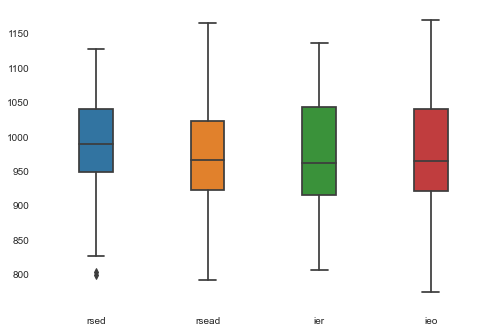

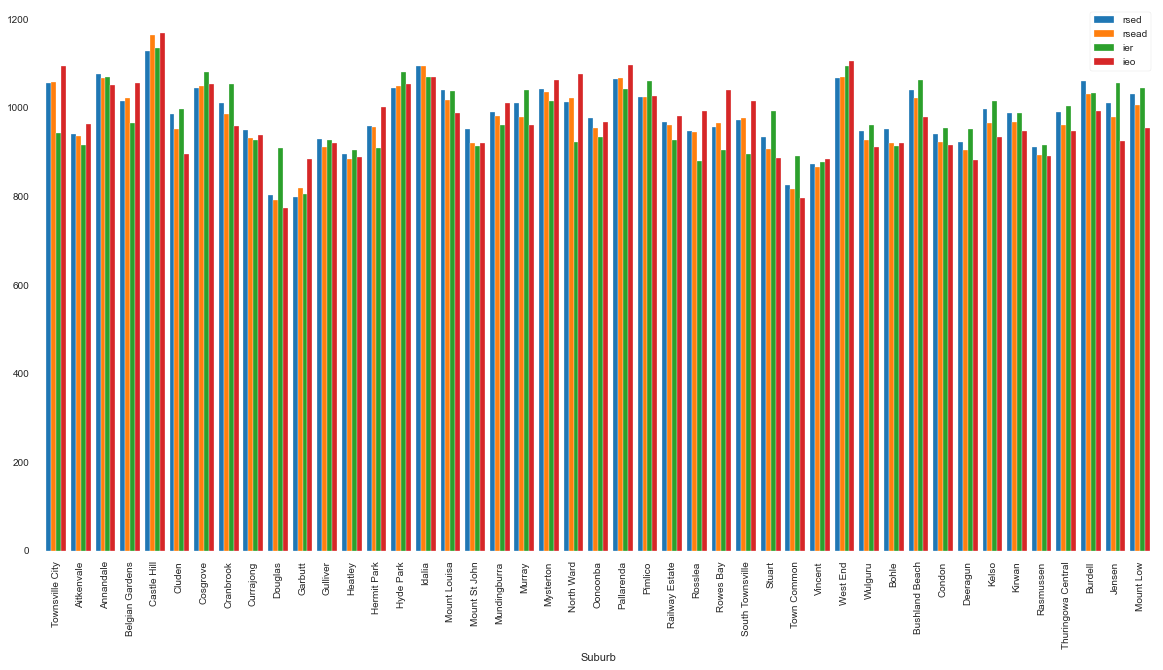

In [28]:
socioeconomic = sns.boxplot(data=[df_ec_ac['rsed'],df_ec_ac['rsead'],df_ec_ac['ier'],df_ec_ac['ieo']], width=0.3)
socioeconomic.set_xticklabels(['rsed','rsead','ier','ieo'], rotation=0)
ax = df_ec_ac.plot.bar(x='Suburb', y=['rsed','rsead','ier','ieo'],figsize=(20,10),width=0.8, rot=90)
print('Socio-Economic Disadvantage is worse in:' , '\n\r', df_ec_ac.nsmallest(1,'rsed')['Suburb'])

The suburbs best serviced with Public Transport are: 
 10            Garbutt
0     Townsville City
8           Currajong
Name: Suburb, dtype: object


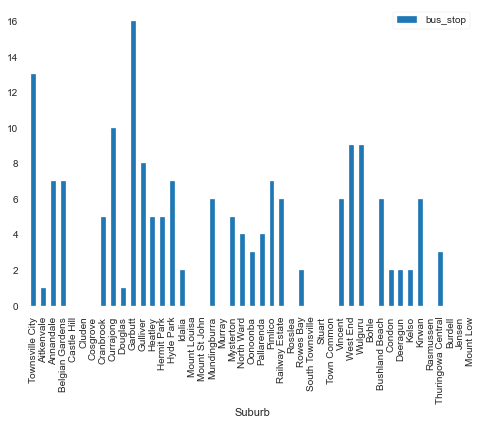

In [29]:
print('The suburbs best serviced with Public Transport are:' , '\n\r', df_ec_ac.nlargest(3,'bus_stop')['Suburb'])
ax = df_ec_ac.plot.bar(x='Suburb', y=['bus_stop'], rot=90)

Property Crime is worse in: 
 39        Kirwan
1     Aitkenvale
10       Garbutt
Name: Suburb, dtype: object
Personal Crime is worse in: 
 0     Townsville City
39             Kirwan
10            Garbutt
Name: Suburb, dtype: object
Property Crime is least in: 
 9      Douglas
32    West End
19      Murray
Name: Suburb, dtype: object
Personal Crime is least in: 
 9         Douglas
30    Town Common
32       West End
Name: Suburb, dtype: object


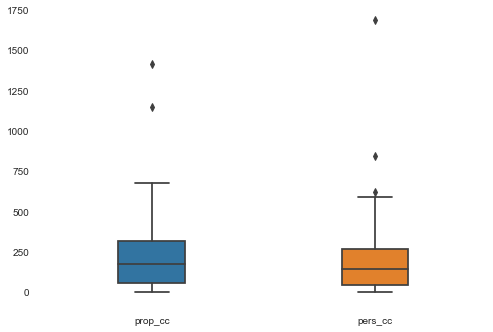

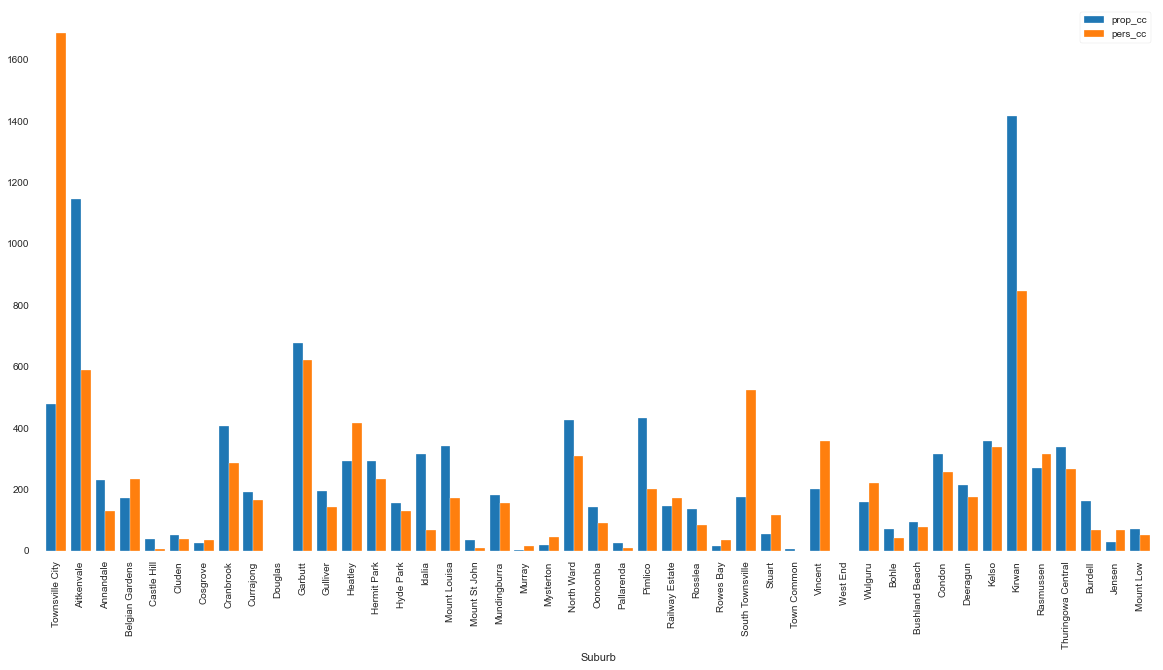

In [30]:
crime = sns.boxplot(data=[df_ec_ac['prop_cc'],df_ec_ac['pers_cc']], width=0.3)
crime.set_xticklabels(['prop_cc','pers_cc'], rotation=0)
ax = df_ec_ac.plot.bar(x='Suburb', y=['prop_cc','pers_cc'],figsize=(20,10),width=0.8, rot=90)
print('Property Crime is worse in:' , '\n\r', df_ec_ac.nlargest(3,'prop_cc')['Suburb'])
print('Personal Crime is worse in:' , '\n\r', df_ec_ac.nlargest(3,'pers_cc')['Suburb'])
print('Property Crime is least in:' , '\n\r', df_ec_ac.nsmallest(3,'prop_cc')['Suburb'])
print('Personal Crime is least in:' , '\n\r', df_ec_ac.nsmallest(3,'pers_cc')['Suburb'])

Animal complaints are worse in: 
 39     Kirwan
38      Kelso
9     Douglas
Name: Suburb, dtype: object


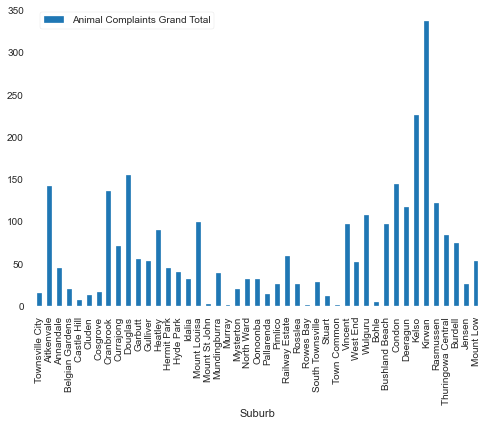

In [31]:
print('Animal complaints are worse in:' , '\n\r', df_ec_ac.nlargest(3,'Animal Complaints Grand Total')['Suburb'])
ax = df_ec_ac.plot.bar(x='Suburb', y=['Animal Complaints Grand Total'], rot=90)

Aggressive Animals are worse in: 
 38        Kelso
39       Kirwan
7     Cranbrook
Name: Suburb, dtype: object
Attack complaints are worse in: 
 39       Kirwan
38        Kelso
40    Rasmussen
Name: Suburb, dtype: object
Animal noise complaints are worse in: 
 39            Kirwan
38             Kelso
35    Bushland Beach
Name: Suburb, dtype: object


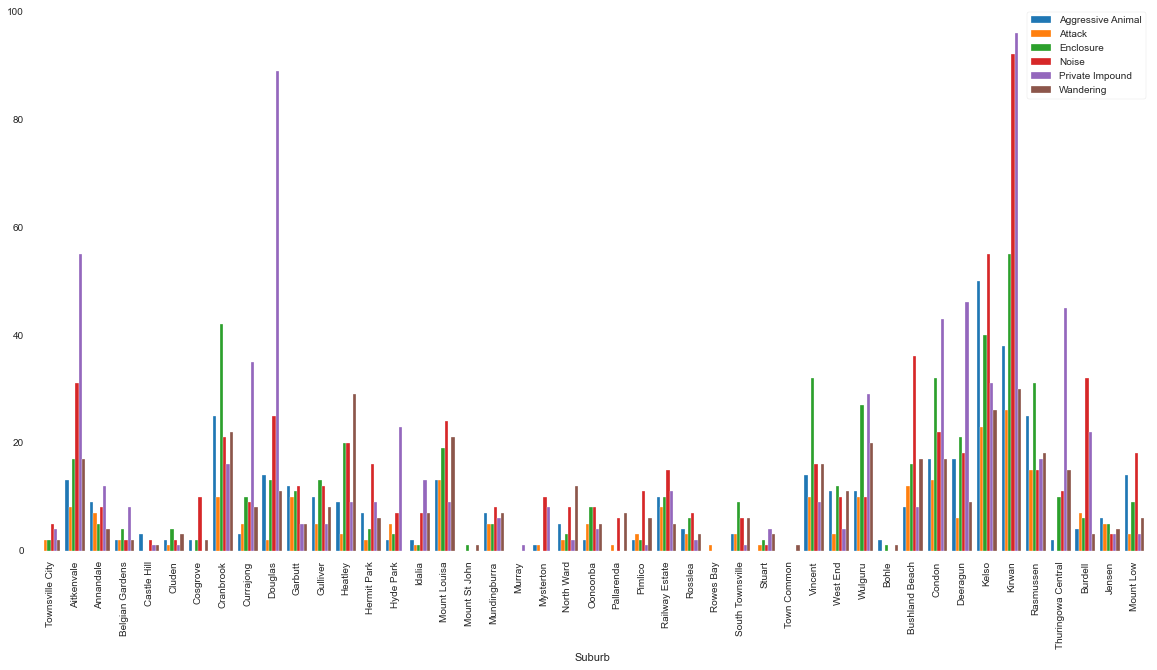

In [32]:
print('Aggressive Animals are worse in:' , '\n\r', df_ec_ac.nlargest(3,'Aggressive Animal')['Suburb'])
print('Attack complaints are worse in:' , '\n\r', df_ec_ac.nlargest(3,'Attack')['Suburb'])
print('Animal noise complaints are worse in:' , '\n\r', df_ec_ac.nlargest(3,'Noise')['Suburb'])
ax = df_ec_ac.plot.bar(x='Suburb', y=['Aggressive Animal','Attack','Enclosure','Noise','Private Impound','Wandering'],figsize=(20,10),width=0.8, rot=90)

The suburbs best serviced with most Venues are: 
 0     Townsville City
21         North Ward
1          Aitkenvale
Name: Suburb, dtype: object


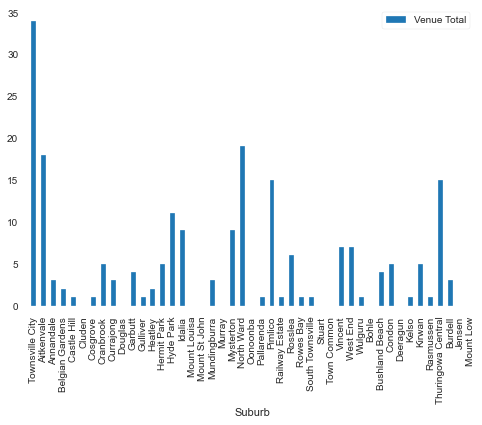

In [33]:
df_ec_ac['Venue Total'] = df_ec_ac.iloc[:, -6:].sum(axis=1)
print('The suburbs best serviced with most Venues are:' , '\n\r', df_ec_ac.nlargest(3,'Venue Total')['Suburb'])
ax = df_ec_ac.plot.bar(x='Suburb', y=['Venue Total'], rot=90)
del df_ec_ac['Venue Total']

There are more Cafes in: 
 0     Townsville City
1          Aitkenvale
24            Pimlico
Name: Suburb, dtype: object
There are more restaurants in: 
 0     Townsville City
1          Aitkenvale
21         North Ward
Name: Suburb, dtype: object
There are more entertainment venues in: 
 13           Hermit Park
36                Condon
41    Thuringowa Central
Name: Suburb, dtype: object


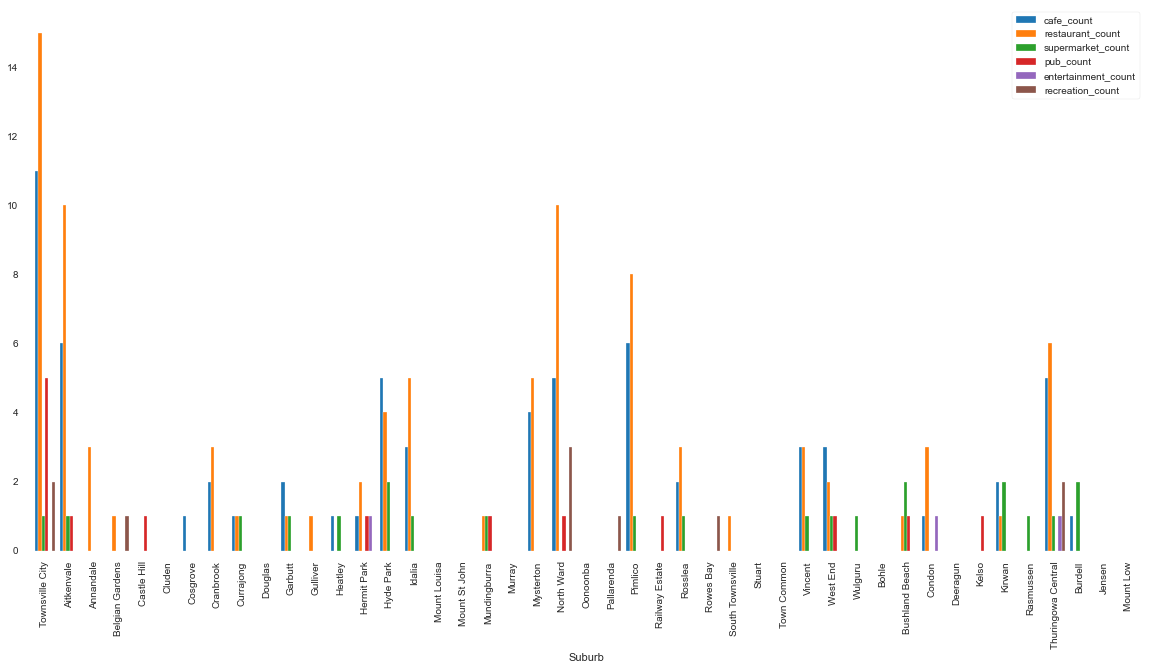

In [34]:
print('There are more Cafes in:' , '\n\r', df_ec_ac.nlargest(3,'cafe_count')['Suburb'])
print('There are more restaurants in:' , '\n\r', df_ec_ac.nlargest(3,'restaurant_count')['Suburb'])
print('There are more entertainment venues in:' , '\n\r', df_ec_ac.nlargest(3,'entertainment_count')['Suburb'])
ax = df_ec_ac.plot.bar(x='Suburb', y=['cafe_count','restaurant_count','supermarket_count','pub_count','entertainment_count','recreation_count'],figsize=(20,10),width=0.8, rot=90)

In [35]:
# how features are correlated
corr = df_ec_ac.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,latitude,longitude,rsed,rsead,ier,ieo,bus_stop,Aggressive Animal,Attack,Enclosure,Noise,Private Impound,Wandering,Animal Complaints Grand Total,prop_cc,pers_cc,council_fac,cafe_count,restaurant_count,supermarket_count,pub_count,entertainment_count,recreation_count
latitude,1.00,-0.24,0.17,0.23,0.02,0.29,0.08,-0.43,-0.35,-0.41,-0.20,-0.38,-0.36,-0.40,-0.20,-0.09,-0.01,-0.01,-0.02,0.02,0.09,-0.17,0.21
longitude,-0.24,1.00,0.07,0.15,-0.16,0.34,0.28,-0.36,-0.31,-0.31,-0.37,-0.26,-0.27,-0.36,-0.03,0.14,0.19,0.22,0.26,-0.10,0.20,-0.08,0.15
rsed,0.17,0.07,1.00,0.98,0.83,0.84,-0.06,-0.16,-0.10,-0.24,-0.03,-0.27,-0.17,-0.20,-0.09,-0.07,0.07,0.19,0.22,0.07,0.24,-0.07,0.17
rsead,0.23,0.15,0.98,1.00,0.78,0.92,0.01,-0.21,-0.15,-0.29,-0.07,-0.30,-0.21,-0.25,-0.08,-0.04,0.09,0.25,0.27,0.08,0.29,-0.08,0.21
ier,0.02,-0.16,0.83,0.78,1.00,0.53,-0.16,-0.02,-0.03,-0.10,0.06,-0.09,-0.05,-0.04,-0.18,-0.30,-0.14,0.02,-0.01,0.07,-0.01,-0.08,-0.10
ieo,0.29,0.34,0.84,0.92,0.53,1.00,0.17,-0.29,-0.23,-0.37,-0.18,-0.37,-0.29,-0.34,-0.03,0.07,0.20,0.35,0.37,0.06,0.36,-0.06,0.34
bus_stop,0.08,0.28,-0.06,0.01,-0.16,0.17,1.00,0.04,0.17,0.11,0.06,0.02,0.10,0.08,0.29,0.48,0.25,0.41,0.34,0.37,0.37,-0.03,0.18
Aggressive Animal,-0.43,-0.36,-0.16,-0.21,-0.02,-0.29,0.04,1.00,0.88,0.88,0.79,0.54,0.76,0.88,0.50,0.25,-0.16,-0.13,-0.14,0.11,-0.01,0.01,-0.22
Attack,-0.35,-0.31,-0.10,-0.15,-0.03,-0.23,0.17,0.88,1.00,0.87,0.83,0.50,0.73,0.86,0.59,0.33,-0.20,-0.09,-0.11,0.35,-0.01,-0.02,-0.24
Enclosure,-0.41,-0.31,-0.24,-0.29,-0.10,-0.37,0.11,0.88,0.87,1.00,0.77,0.59,0.87,0.91,0.55,0.32,-0.11,-0.07,-0.11,0.25,-0.09,0.08,-0.21


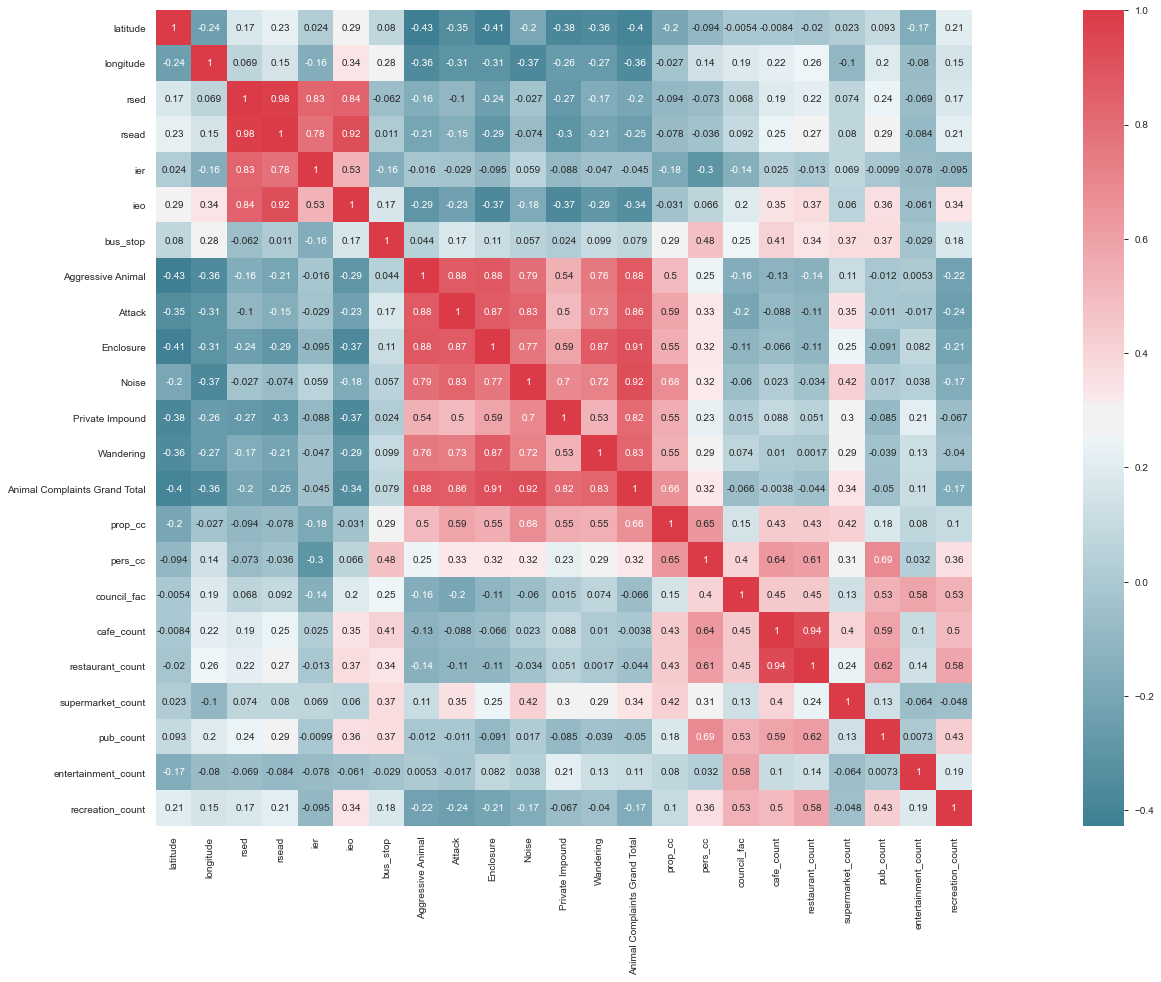

In [36]:
f, ax = plt.subplots(figsize=(40, 15))
corr = df_ec_ac.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, annot=True, ax=ax)

In [37]:
# Identify any moderate or strong correlations between different domains (ie btween crime and venues)
c = df_ec_ac.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort")

ec_domain=['rsed','rsead','ier','ieo']
pt_domain=['bus_stop']
ac_domain=['Aggressive Animal','Attack','Enclosure','Noise','Private Impound','Wandering','Animal Complaints Grand Total']
cd_domain=['prop_cc','pers_cc']
ccf_domain=['council_fac']
ven_domain=['cafe_count','restaurant_count','supermarket_count','pub_count','entertainment_count','recreation_count']

strong_corrs=[]
for i in range(len(so)):
    if so[i] >= 0.6 and so[i]<1.0:
        if  (((so.index[i])[0] in ec_domain) and ((so.index[i])[1] in ec_domain)):
            pass
        elif (((so.index[i])[0] in pt_domain) and ((so.index[i])[1] in pt_domain)):
            pass
        elif (((so.index[i])[0] in ac_domain) and ((so.index[i])[1] in ac_domain)):
            pass
        elif (((so.index[i])[0] in cd_domain) and ((so.index[i])[1] in cd_domain)):
            pass
        elif (((so.index[i])[0] in ccf_domain) and ((so.index[i])[1] in ccf_domain)):
            pass
        elif (((so.index[i])[0] in ven_domain) and ((so.index[i])[1] in ven_domain)):
            pass
        else:
            strong_corrs.append(((so.index[i])[0],(so.index[i])[1],so[i]))

strong_corrs           

[('restaurant_count', 'pers_cc', 0.6106126314501122),
 ('pers_cc', 'restaurant_count', 0.6106126314501122),
 ('cafe_count', 'pers_cc', 0.6368978189324032),
 ('pers_cc', 'cafe_count', 0.6368978189324032),
 ('Animal Complaints Grand Total', 'prop_cc', 0.6625400410640956),
 ('prop_cc', 'Animal Complaints Grand Total', 0.6625400410640956),
 ('prop_cc', 'Noise', 0.6816049286646086),
 ('Noise', 'prop_cc', 0.6816049286646086),
 ('pers_cc', 'pub_count', 0.6925710223471985),
 ('pub_count', 'pers_cc', 0.6925710223471985)]

There is a strong correlation between the number of restaurants (type) venues and the number of cafe (type) venues.
There is a moderate correlation between the number of Personal Crime incidents and the number of Pub (type) venues.
There is a moderate correlation between the number of Property Crimes incidents and the number of Animal Noise Complaints. 

## Cluster Analysis

In [38]:
#prepare data for KMeans

X = df_ec_ac.values[:,3:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)

In [39]:
# function returns the WSS score (squared errors for all points)-used to identify elbow point; 
# the Inertia score (spread of points within a cluster)-used to identify elbow point;
# the Silhouette score (how far between clusters)-greater value is better clustering;
# for values of k between 1 to kmax

def calculate_Errors(points, kmax):
    init={}
    sse = []
    sil = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        if k < 2:
            sil.append(0)
        else:
            labels = kmeans.labels_
            sil.append(silhouette_score(points, labels, metric = 'euclidean'))
        init[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
        sse.append(curr_sse)

    return (sse,init,sil)

In [40]:
# function to plot errors and Silhouette score

def plot_Errors(sse_errors2,sil_error2,init_errors):

    plt.figure(figsize=(12, 6))

    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()

    ax1.set_xlabel('K value')
    ax1.set_ylabel('SSE and Inertia', color='b')
    ax2.set_ylabel('Silhoutte index', color='brown')

    ax1.plot(range(1, kmax+1), sse_errors2, color='red', linestyle='dashed', marker='o',
             markerfacecolor='blue', markersize=10, label="sse errors: identify elbow point")

    ax1.plot(range(1, kmax+1), list(init_errors.values()), color='green', linestyle='dashed', marker='o',
             markerfacecolor='yellow', markersize=10, label="inertia measure: identify elbow point")

    ax2.plot(range(1, kmax+1), sil_error2, color='brown', linestyle='dashed', marker='o',
             markerfacecolor='violet', markersize=10, label="silhouette measure: greater is better")


    plt.title('Error Measures and K Values')
    plt.xticks(range(1,kmax+1))

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc=1)

<Figure size 864x432 with 0 Axes>

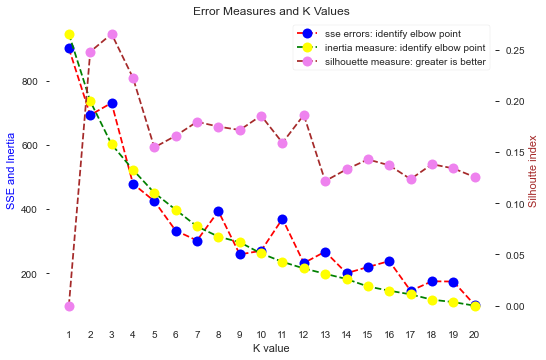

In [41]:
#full dataset errors and Silhouette

kmax = 20
sserrors_all = calculate_Errors(cluster_dataset,kmax)

#extract metrics from returned tuple
raw_sse_errors = sserrors_all[0]
raw_init_errors = sserrors_all[1]
raw_sil_errors = sserrors_all[2]

#scale metric so they appear on same plot
raw_sse_errors2 = [i * 10 for i in raw_sse_errors]
raw_sil_error2 = [i * 1 for i in raw_sil_errors]

plot_Errors(raw_sse_errors2,raw_sil_error2,raw_init_errors)

<Figure size 864x432 with 0 Axes>

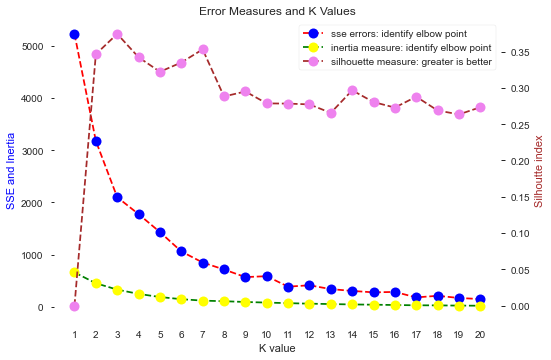

In [42]:
#PCA errors and Silhouette

pca = PCA(n_components=3)
pca_data = StandardScaler().fit_transform(X)
principalComponents = pca.fit_transform(pca_data)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

kmax = 20
sserrors_all = calculate_Errors(principalComponents,kmax)

#extract metrics from returned tuple
pca_sse_errors = sserrors_all[0]
pca_init_errors = sserrors_all[1]
pca_sil_errors = sserrors_all[2]

#scale metric so they appear on same plot
pca_sse_errors2 = [i * 10 for i in pca_sse_errors]
pca_sil_error2 = [i * 1 for i in pca_sil_errors]

plot_Errors(pca_sse_errors2,pca_sil_error2,pca_init_errors)

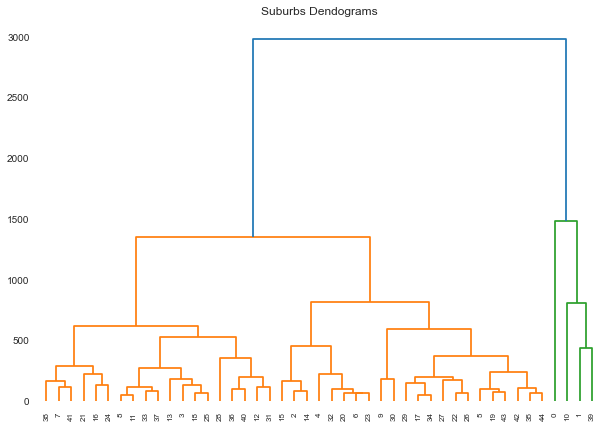

In [43]:
#plot dendrogram to identify number of clusters to use

D = df_ec_ac.values[:,3:]

plt.figure(figsize=(10, 7))
plt.title("Suburbs Dendograms")
dend = shc.dendrogram(shc.linkage(D, method='ward'))


## Selection of the best number of Clusters to use  
This is a very small dataset for KMeans modelling. I could not find any definitive answer regarding using KMeans on such a small dataset. The lack of a clearly identifiable best k value in the Error plots and the Silhouette Score most likely is due to the small data set. I did try reducing the number of features manually, by summing some features and removing some strongly correlated features, but this did not improve the result. A Principal Components Analysis was done to obtain a much smaller feature set. This gave a better case count to feature set ratio. The error plots and Silhouette Score for the PCA dataset did help to select a k value. Dendrogram plot helped justify the use of 3 clusters.

In [44]:
num_clusters = 3

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_


In [45]:
%matplotlib notebook

<IPython.core.display.Javascript object>


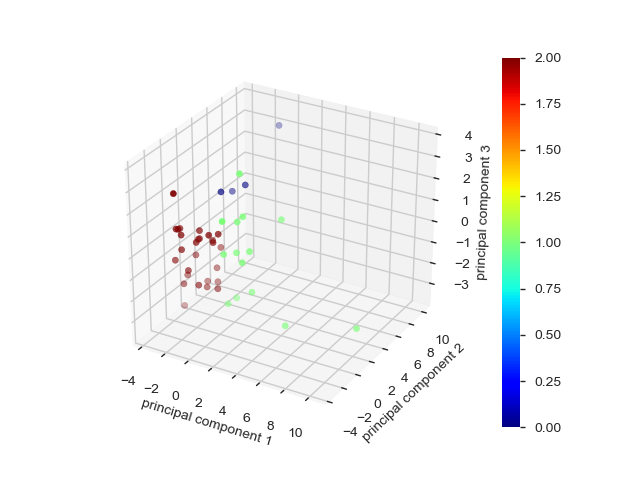

In [46]:
# Visualize KMeans result for PCA dataset using the Kmeans derived labels (clusters)

# Add Labels to PCA result dataframe
principalDf["Labels"] = labels

def scatter3d(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    #ax = Axes3D(fig)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap)
    ax.set_xlabel('principal component 1', fontsize = 10)
    ax.set_ylabel('principal component 2', fontsize = 10)
    ax.set_zlabel('principal component 3', fontsize = 10)
    plt.show()
    
scatter3d(principalDf['principal component 1'],principalDf['principal component 2'],principalDf['principal component 3'],principalDf['Labels'])

Though poorly defined, it is possible to identify the 3 clusters.

In [47]:
%matplotlib inline

In [48]:
# Add cluster labels to main dataset

df_ec_ac["Labels"] = labels
df_ec_ac.head()

,Suburb,latitude,longitude,rsed,rsead,ier,ieo,bus_stop,Aggressive Animal,Attack,...,prop_cc,pers_cc,council_fac,cafe_count,restaurant_count,supermarket_count,pub_count,entertainment_count,recreation_count,Labels
0,Townsville City,-19.26,146.82,1055,1059,943,1094,13.00,0.00,2.00,...,476.00,1687.00,4.00,11.00,15.00,1.00,5.00,0.00,2.00,0
1,Aitkenvale,-19.30,146.77,940,937,915,964,1.00,13.00,8.00,...,1146.00,589.00,1.00,6.00,10.00,1.00,1.00,0.00,0.00,1
2,Annandale,-19.31,146.78,1077,1068,1069,1051,7.00,9.00,7.00,...,230.00,128.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,2
3,Belgian Gardens,-19.25,146.79,1015,1021,966,1056,7.00,2.00,2.00,...,172.00,232.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,2
4,Castle Hill,-19.26,146.80,1127,1164,1135,1169,0.00,3.00,0.00,...,37.00,4.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,2


In [49]:
# create map of Townsville using latitude and longitude values

f = folium.Figure(width=800, height=500)

map_townsville = folium.Map(location=[latitude, longitude], tiles="openstreetmap", zoom_start=11).add_to(f)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to map
markers_colors = []
for lat, lng, suburb, cluster in zip(df_ec_ac['latitude'], df_ec_ac['longitude'], df_ec_ac['Suburb'], df_ec_ac['Labels']):
    #label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    label = '{}'.format(suburb)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_townsville)  
    
map_townsville

In [50]:
# print suburb clusters

for k in range(0, num_clusters):
    print('Suburbs in Group ',k,'\n\r',df_ec_ac.loc[df_ec_ac['Labels'] == k].Suburb)

Suburbs in Group  0 
 0        Townsville City
13           Hermit Park
21            North Ward
41    Thuringowa Central
Name: Suburb, dtype: object
Suburbs in Group  1 
 1         Aitkenvale
7          Cranbrook
9            Douglas
10           Garbutt
12           Heatley
16      Mount Louisa
31           Vincent
33           Wulguru
35    Bushland Beach
36            Condon
37          Deeragun
38             Kelso
39            Kirwan
40         Rasmussen
Name: Suburb, dtype: object
Suburbs in Group  2 
 2            Annandale
3      Belgian Gardens
4          Castle Hill
5               Cluden
6             Cosgrove
8            Currajong
11            Gulliver
14           Hyde Park
15              Idalia
17       Mount St John
18        Mundingburra
19              Murray
20           Mysterton
22            Oonoonba
23          Pallarenda
24             Pimlico
25      Railway Estate
26             Rosslea
27           Rowes Bay
28    South Townsville
29              Stuart
3

## Descriptive Statistics for the Different Suburbs ( the Label is the Cluster Number)

In [51]:
df_ec_ac[["rsed",'rsead','ier','ieo','Labels']].groupby("Labels").agg({'rsed': ['min', 'max', 'median','mean'],
                                                                 'rsead': ['min', 'max', 'median', 'mean'],
                                                                 'ier': ['min', 'max', 'median', 'mean'],
                                                                 'ieo': ['min', 'max', 'median', 'mean']})

rsed                      rsead                      ier               \
        min   max median    mean   min   max median   mean  min   max median   
Labels                                                                         
0       958  1055   1002 1004.25   957  1059 991.50 999.75  908  1004 932.50   
1       799  1041    940  936.21   791  1022 924.50 921.57  805  1062 953.50   
2       826  1127   1010 1001.70   816  1164 980.00 991.85  879  1135 996.00   

               ieo                       
         mean  min   max median    mean  
Labels                                   
0      944.25  947  1094   1039 1029.75  
1      953.43  774   988    913  914.21  
2      994.15  797  1169    993  994.96

In [52]:
df_ec_ac[["prop_cc", "pers_cc",'Animal Complaints Grand Total','Labels']].groupby("Labels").agg({'prop_cc': ['min', 'max', 'median','mean'],
                                                                 'pers_cc': ['min', 'max', 'median', 'mean'],
                                                                 'Animal Complaints Grand Total': ['min', 'max', 'median', 'mean'],})

prop_cc                       pers_cc                        \
           min     max median   mean     min     max median   mean   
Labels                                                               
0       293.00  476.00 381.00 382.75  232.00 1687.00 288.00 623.75   
1         0.00 1416.00 302.50 420.00    0.00  845.00 300.00 332.93   
2         0.00  433.00  71.00 113.78    0.00  524.00  67.00  96.70   

       Animal Complaints Grand Total                     
                                 min  max median   mean  
Labels                                                   
0                                 15   83     38  43.50  
1                                 55  337    119 137.14  
2                                  1   74     25  28.15

In [53]:
df_ec_ac[["cafe_count", "restaurant_count",'Labels']].groupby("Labels").agg({'cafe_count': ['min', 'max', 'median','mean'],
                                                                 'restaurant_count': ['min', 'max', 'median', 'mean']})

cafe_count                   restaurant_count                  
              min   max median mean              min   max median mean
Labels                                                                
0            1.00 11.00   5.00 5.50             2.00 15.00   8.00 8.25
1            0.00  6.00   0.50 1.21             0.00 10.00   0.50 1.57
2            0.00  6.00   0.00 0.96             0.00  8.00   0.00 1.30

In [54]:
df_ec_ac[["supermarket_count",'pub_count','entertainment_count','recreation_count','Labels']].groupby("Labels").agg({'supermarket_count': ['min', 'max', 'median','mean'],
                                                                 'pub_count': ['min', 'max', 'median', 'mean'],
                                                                 'entertainment_count': ['min', 'max', 'median', 'mean'],
                                                                 'recreation_count': ['min', 'max', 'median', 'mean']})

supermarket_count                  pub_count                   \
                     min  max median mean       min  max median mean   
Labels                                                                 
0                   0.00 1.00   0.50 0.50      0.00 5.00   1.00 1.75   
1                   0.00 2.00   1.00 0.71      0.00 1.00   0.00 0.21   
2                   0.00 2.00   0.00 0.37      0.00 1.00   0.00 0.15   

       entertainment_count                  recreation_count                   
                       min  max median mean              min  max median mean  
Labels                                                                         
0                     0.00 1.00   0.50 0.50             0.00 3.00   2.00 1.75  
1                     0.00 1.00   0.00 0.07             0.00 0.00   0.00 0.00  
2                     0.00 0.00   0.00 0.00             0.00 1.00   0.00 0.11

## Boxplots for each feature, for each cluster

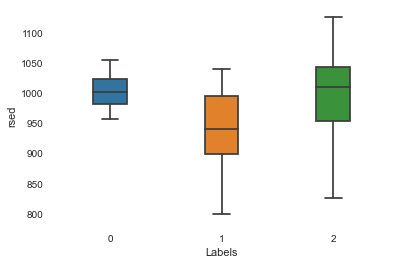

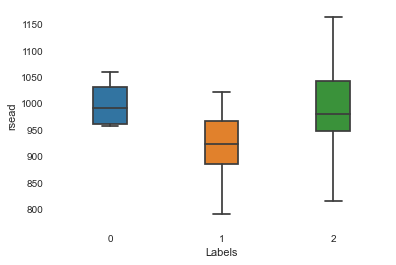

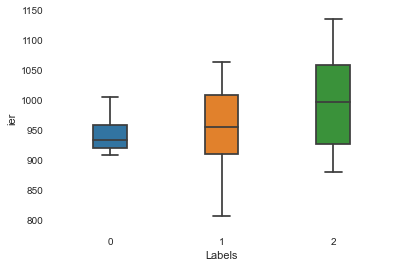

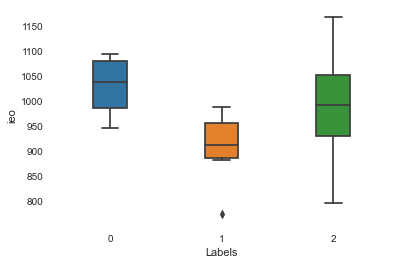

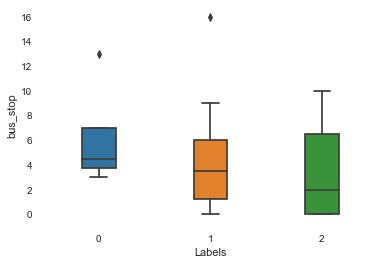

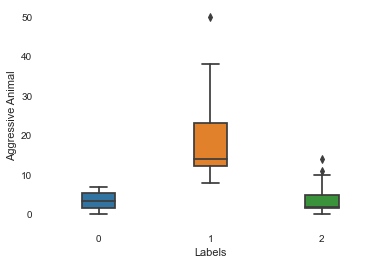

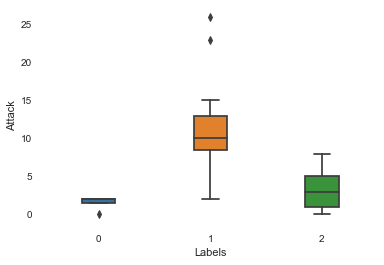

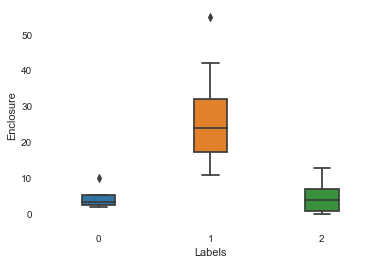

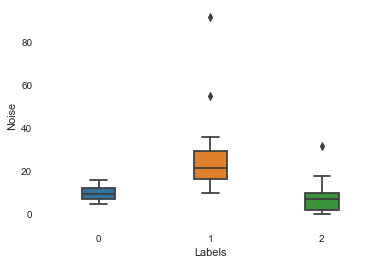

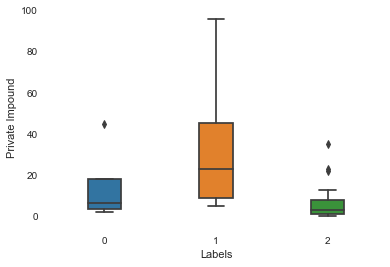

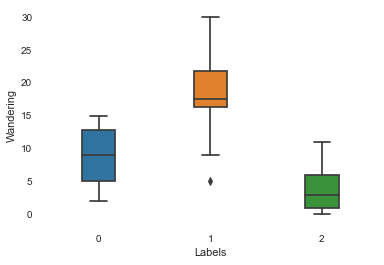

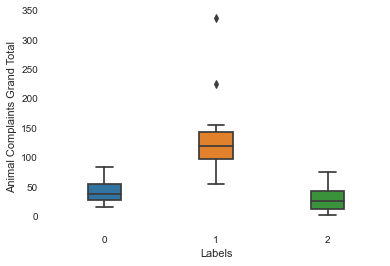

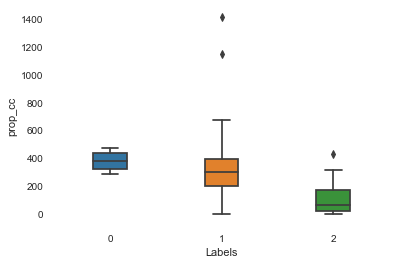

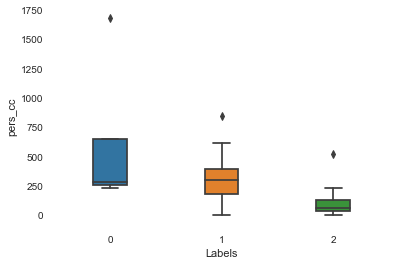

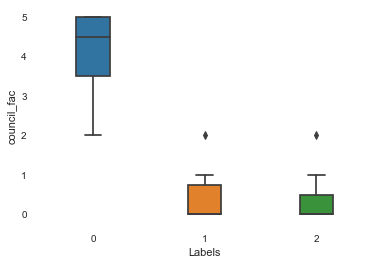

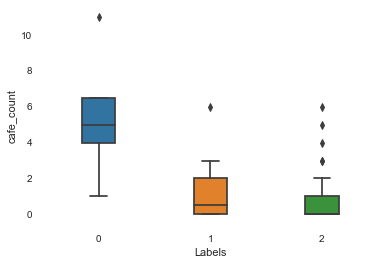

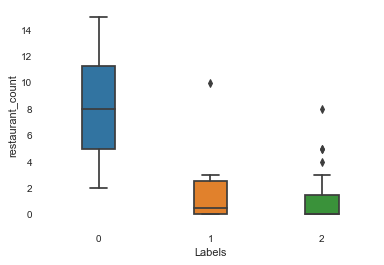

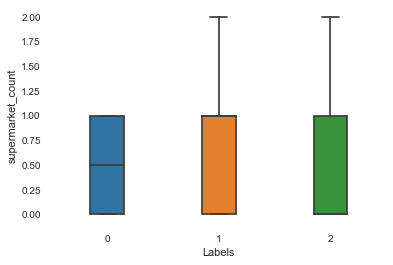

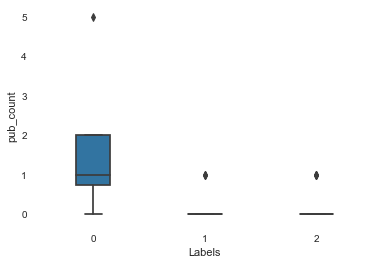

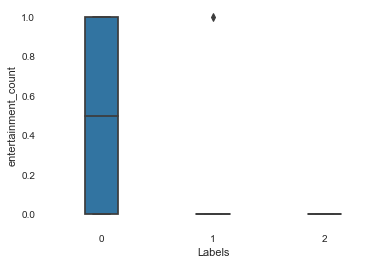

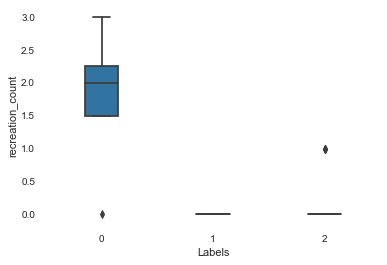

In [55]:
for ind in range(len(column_Names)):
    if (ind > 2):
        sns.boxplot( x=df_ec_ac["Labels"], y=df_ec_ac[column_Names[ind]], width=0.3);
        plt.show()